<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example02_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データのARモデル構築

1. サンプルデータの読み込み（訓練データとテストデータへの分割）
1. 原系列 $y_n$ の偏自己相関関数(PARCOR)のコレログラムとADF検定
1. 階差系列 $\Delta y_n=y_n-y_{n-1}$ の偏自己相関関数(PARCOR)のコレログラムとADF検定

参考図書

- 時系列解析入門／北川源四郎／岩波書店
- 時系列解析／島田直希／共立出版
- 時系列解析入門〔第２版〕／宮野尚哉・後藤田浩／サイエンス社

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [1]:
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## サンプルデータの読み込み

CSV形式の河川水位観測データを読込


In [2]:
strtitle = '河川水位'
maxlag = 50 # hours

# ファイルをアップロードする
#from google.colab import files
#uploaded_file = files.upload()
#filename = next(iter(uploaded_file))
#print(filename)

#観測データのファイル
filename = './data/practice02_01.csv'

#観測データ（空白区切り）の読み込み
df_full = pd.read_csv(filename)
df_full['t'] = pd.to_datetime(df_full['t'])
display(df_full)

,t,y
0,2019-07-23 01:00:00+09:00,42.08
1,2019-07-23 02:00:00+09:00,42.07
2,2019-07-23 03:00:00+09:00,42.11
3,2019-07-23 04:00:00+09:00,42.10
4,2019-07-23 05:00:00+09:00,42.12
...,...,...
8778,2020-07-22 19:00:00+09:00,43.76
8779,2020-07-22 20:00:00+09:00,43.67
8780,2020-07-22 21:00:00+09:00,43.55
8781,2020-07-22 22:00:00+09:00,43.34


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値

以下では，2020年3月1日0時～2020年3月31日23時までのデータで分析を進める。

- 訓練データ： 2020年3月1日0時～2020年3月28日23時
- テストデータ： 2020年3月29日0時～2020年3月31日23時 

In [3]:
# 解析期間の設定
dts = '2020040100' # '2020030100' # 開始日時
dte = '2020042723' # '2020032823' # 終了日時
# 予測期間の設定
dtsp = '2020032900' # 予測開始日時
dtep = '2020033123' # 予測終了日時

# datetime 形式に変換
dts00 = pd.to_datetime(dts+'00').tz_localize('Asia/Tokyo')
dte00 = pd.to_datetime(dte+'00').tz_localize('Asia/Tokyo')
df_timeseries = df_full[(df_full.t>=dts00) & (df_full.t<=dte00)]
display(df_timeseries)

,t,y
6071,2020-04-01 00:00:00+09:00,42.85
6072,2020-04-01 01:00:00+09:00,42.79
6073,2020-04-01 02:00:00+09:00,42.78
6074,2020-04-01 03:00:00+09:00,42.78
6075,2020-04-01 04:00:00+09:00,42.78
...,...,...
6714,2020-04-27 19:00:00+09:00,42.98
6715,2020-04-27 20:00:00+09:00,43.00
6716,2020-04-27 21:00:00+09:00,43.01
6717,2020-04-27 22:00:00+09:00,42.88


## 欠損データの補間

データの欠損箇所があるため，前のデータで補間する。pandas.Series の以下のメソッドを利用できる。

- fillna(method='ffill')

In [4]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
display(df_timeseries)

,t,y,y_fillna
6071,2020-04-01 00:00:00+09:00,42.85,42.85
6072,2020-04-01 01:00:00+09:00,42.79,42.79
6073,2020-04-01 02:00:00+09:00,42.78,42.78
6074,2020-04-01 03:00:00+09:00,42.78,42.78
6075,2020-04-01 04:00:00+09:00,42.78,42.78
...,...,...,...
6714,2020-04-27 19:00:00+09:00,42.98,42.98
6715,2020-04-27 20:00:00+09:00,43.00,43.00
6716,2020-04-27 21:00:00+09:00,43.01,43.01
6717,2020-04-27 22:00:00+09:00,42.88,42.88


## 原系列 $y_n$ のプロット


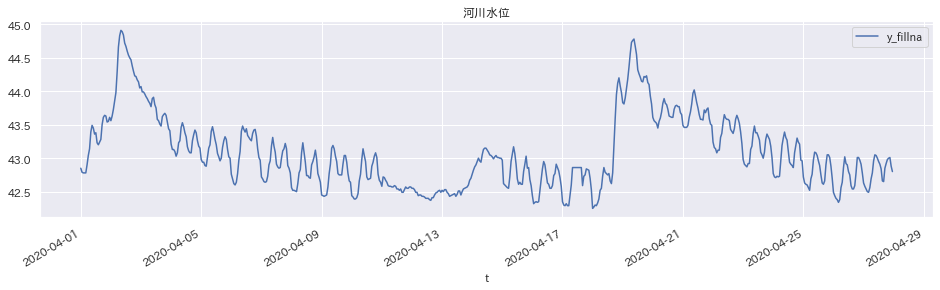

In [5]:
ax = df_timeseries.plot(x='t', y='y_fillna', figsize=(16,4), title=strtitle)


## 原系列 $y_n$ の自己相関関数

原系列 $y_n$ の時間依存性を確かめるために，自己相関関数のコレログラムを描画する。
自己相関関数のコレログラム描画にはstatsmodelsライブラリを利用できる。

- acf()
- plot_acf()

なお，コレログラム中の青色の帯は 95%信頼区間で，帯の外側の値を有意とみなす。


y_acf:
[1.         0.98026398 0.93941645 0.88675158 0.83220864 0.78638984
 0.75640492 0.74280138 0.74137346 0.74749918 0.75277787 0.74945446
 0.73404761 0.70668437 0.66930576 0.6260904  0.5843008  0.55206123
 0.53408345 0.53187045 0.54390546 0.56417994 0.58445134 0.59570447
 0.59065309 0.56213772 0.51941587 0.46920785 0.42040582 0.38072241
 0.35466403 0.34325989 0.34501656 0.35412995 0.36388302 0.36737543
 0.36138313 0.34547011 0.32080674 0.29120089 0.26245752]


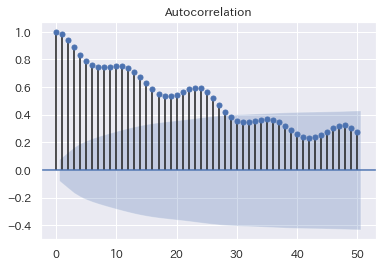

In [6]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

y_series = df_timeseries['y_fillna']
y_acf = sm.tsa.stattools.acf(y_series)
print('y_acf:')
print(y_acf)
fig = sm.graphics.tsa.plot_acf(y_series, lags=maxlag)




## 原系列 $y_n$ の偏自己相関関数(PARCOR)

原系列 $y_n$ の時間依存性を確かめるために，偏自己相関関数(PARCOR)のコレログラムを描画する。
偏自己相関関数のコレログラム描画にはstatsmodelsライブラリを利用できる。

- pacf()
- plot_pacf()

y_pacf:
[ 1.          0.98177907 -0.59721294 -0.01989064  0.16680785  0.27949149
  0.2251742   0.044432   -0.05895671  0.0370893  -0.08957934 -0.12153902
 -0.04984302 -0.00311053 -0.04776858 -0.07096606  0.04217822  0.18873818
  0.13263687  0.06575765  0.07087436  0.02221448 -0.03463702 -0.15616191
 -0.20349593 -0.40341297  0.27888347  0.02940926  0.0155808  -0.10976743
 -0.06208354  0.08555771  0.23918806 -0.04024459  0.07672241 -0.00781394
  0.07686412  0.03425009 -0.04323711 -0.04699567  0.00435407]


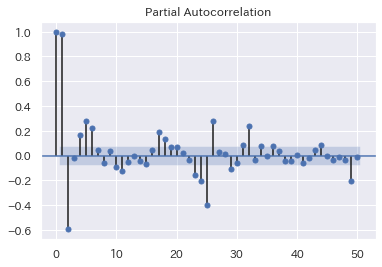

In [7]:
y_pacf = sm.tsa.stattools.pacf(y_series)
print('y_pacf:')
print(y_pacf)
fig = sm.graphics.tsa.plot_pacf(y_series, lags=maxlag)


## 原系列 $y_n$ の定常性の検証

PARCORのコレログラムから24時間間隔での有意な偏相関がみられる。絶対値は1以下なので単位根過程か否かを検証する。

原系列 $y_n$ が定常過程であるかを確認するため，ADF(augmented Dickey-Fuler)検定を実施する。


ADF検定では，
- 帰無仮説 $H_0: \rho=1$（単位根過程）
- 対立仮説 $H_1: 0<\rho <1$ （弱定常過程）

として検定を行う。

帰無仮説が正しいにも関わらず，帰無仮説を棄却する誤りの確率をp値(p-value)という。このp値がある有意水準（significant level）より小さければ，帰無仮説を棄却し，対立仮説を受容する。すなわち，ADF検定のp値が高いと単位根過程であるという仮説を棄却できない（定常過程であるといえない）。





In [8]:
y_adftest = stattools.adfuller(y_series)
print('y_adftest:')
print(y_adftest)

y_adftest:
(-1.8235116737155694, 0.36885284725342926, 19, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, -1380.8119227293055)


## 階差系列 $\Delta y_n$ のプロット

ADF検定結果の2番目の値がp値。原系列 $y_n$ のADF検定の結果，p値が有意水準0.05 よりも大きいため単位根過程という仮説を棄却できない。

そこで，階差系列

$\Delta y_n=y_n-y_{n-1}$
    
の分析を進める。





,t,y,y_fillna,y_fillna_diff
6071,2020-04-01 00:00:00+09:00,42.85,42.85,NaN
6072,2020-04-01 01:00:00+09:00,42.79,42.79,-0.06
6073,2020-04-01 02:00:00+09:00,42.78,42.78,-0.01
6074,2020-04-01 03:00:00+09:00,42.78,42.78,0.00
6075,2020-04-01 04:00:00+09:00,42.78,42.78,0.00
...,...,...,...,...
6714,2020-04-27 19:00:00+09:00,42.98,42.98,0.06
6715,2020-04-27 20:00:00+09:00,43.00,43.00,0.02
6716,2020-04-27 21:00:00+09:00,43.01,43.01,0.01
6717,2020-04-27 22:00:00+09:00,42.88,42.88,-0.13


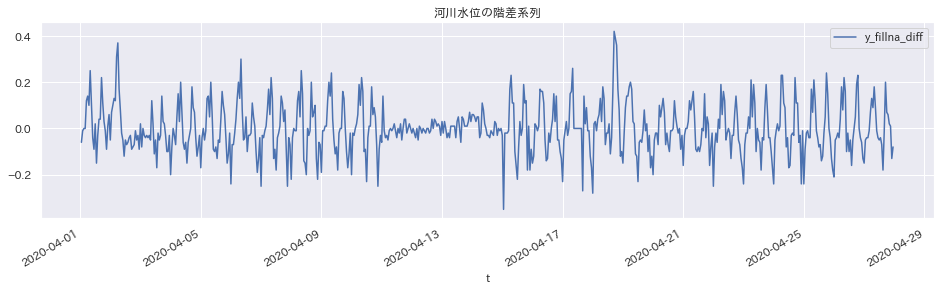

In [9]:
df_timeseries['y_fillna_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
ax = df_timeseries.plot(x='t', y='y_fillna_diff', figsize=(16,4), title=strtitle+'の階差系列')

## 階差系列 $\Delta y_n$ の自己相関関数

階差系列 $\Delta y_n$ の時間依存性を確かめるために，自己相関関数のコレログラムを描画する。

先頭の値のみ非数(nan)であるため，dropna() で削除する．




y_fillna_diff_acf:
[ 1.          0.54545952  0.30930241  0.04804201 -0.22568033 -0.40676226
 -0.42063683 -0.31839819 -0.18657919  0.03179133  0.22318435  0.31024053
  0.31077493  0.25505474  0.14992385 -0.03893594 -0.25181651 -0.36426388
 -0.407965   -0.36907418 -0.21236984 -0.0012157   0.23432697  0.42411648
  0.60907412  0.37338176  0.19839528 -0.0306843  -0.23136218 -0.35037156
 -0.37352089 -0.3359323  -0.18719911 -0.01523876  0.16591196  0.24267044
  0.25799597  0.22415825  0.12934046 -0.02958343 -0.19802561]


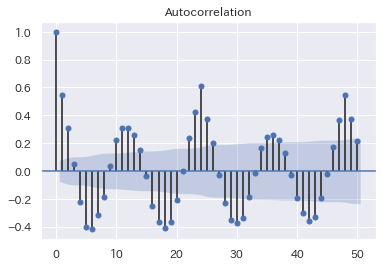

In [10]:
y_diff_series = df_timeseries['y_fillna_diff'].dropna()
y_fillna_diff_acf = sm.tsa.stattools.acf(y_diff_series)
print('y_fillna_diff_acf:')
print(y_fillna_diff_acf)
fig = sm.graphics.tsa.plot_acf(y_diff_series, lags=maxlag)

## 階差系列 $\Delta y_n$ の偏自己相関関数(PARCOR)

階差系列 $\Delta y_n$ の時間依存性を確かめるために，偏自己相関関数(PARCOR)のコレログラムを描画する。

y_fillna_diff_pacf:
[ 1.          0.54630389  0.01683916 -0.18190032 -0.27917247 -0.22982423
 -0.07000752  0.02153087 -0.01926821  0.07860018  0.09553756  0.03600391
  0.00649343  0.03219058  0.05653388 -0.05920005 -0.1849885  -0.12078174
 -0.09366783 -0.09167968 -0.02901298  0.02621654  0.13502663  0.17662474
  0.35535717 -0.18844917 -0.04308098 -0.03238804  0.04570359  0.03752303
 -0.04981964 -0.18164154 -0.05728892 -0.09404355  0.0025479  -0.05721817
 -0.03995335  0.00296471  0.0282626   0.01978347  0.03486679]


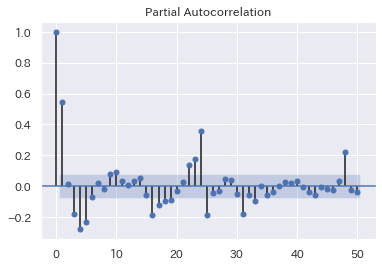

In [11]:
y_fillna_diff_pacf = sm.tsa.stattools.pacf(y_diff_series)
print('y_fillna_diff_pacf:')
print(y_fillna_diff_pacf)
fig = sm.graphics.tsa.plot_pacf(y_diff_series, lags=maxlag)

## 階差系列 $\Delta y_n$ の定常性の検証

PARCORのコレログラムから24時間間隔での有意な偏相関がみられる。絶対値は1以下なので単位根過程か否かを検証する。定常性の検証にADF検定を実施する。

In [12]:
y_diff_adftest = stattools.adfuller(y_diff_series)
print('y_diff_adftest:')
print(y_diff_adftest)

y_diff_adftest:
(-8.512707037784129, 1.1558830749602392e-13, 18, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, -1376.4351277858802)


## 階差系列 $\Delta y_n$ のARモデルの構築

階差系列 $\Delta y_n$ のADF検定の結果，p値が有意水準0.05 よりも小さいため単位根過程という仮説を棄却する。結果として定常過程であることを確認できたため階差系列 $\Delta y_n$ のARモデルを構築する。

ARモデルの構築に statsmodels ライブラリの ar_model モジュールを利用する。

statsmodels の ar_model.AR では、引数 ic に 'aic' を指定すると、 maxlag までの次数の中で最小AIC法により次数pの選択がなされる。

In [13]:
from statsmodels.tsa import ar_model
# ARモデルのインスタンス生成
arpmodel = ar_model.AR(y_diff_series)
# ARモデルの係数パラメータ推定
results = arpmodel.fit(maxlag=maxlag, ic='aic')
print('popt = {:2d}'.format(results.k_ar))

C:\Users\shogo\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
popt = 48


## ARモデルの評価

残差とそのPARCORの表示


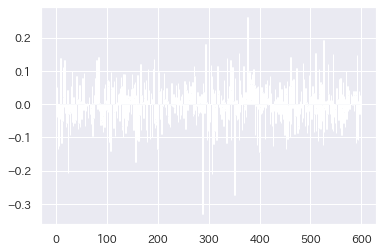

In [14]:
residual = results.resid
bc = plt.bar(range(len(residual)), residual)